# Data

- apartments_(train|test).csv contains information about specific apartments.
- buildings_(train|test).csv contains suplementary information about the building each apartment is located in.
- (apartments|buildings)_meta.json contains meta information about the specific columns


In [1]:
def describe_column(meta):
    """
    Utility function for describing a dataset column (see below for usage)
    """
    def f(x):
        d = pd.Series(name=x.name, dtype=object)
        m = next(m for m in meta if m['name'] == x.name)
        d['Type'] = m['type']
        d['#NaN'] = x.isna().sum()
        d['Description'] = m['desc']
        if m['type'] == 'categorical':
            counts = x.dropna().map(dict(enumerate(m['cats']))).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        elif m['type'] == 'real' or m['type'] == 'integer':
            stats = x.dropna().agg(['mean', 'std', 'min', 'max'])
            d['Statistics'] = ', '.join(f'{s}={v :.1f}' for s, v in stats.items())
        elif m['type'] == 'boolean':
            counts = x.dropna().astype(bool).value_counts().sort_index()
            d['Statistics'] = ', '.join(f'{c}({n})' for c, n in counts.items())
        else:
            d['Statistics'] = f'#unique={x.nunique()}'
        return d
    return f

def describe_data(data, meta):
    desc = data.apply(describe_column(meta)).T
    desc = desc.style.set_properties(**{'text-align': 'left'})
    desc = desc.set_table_styles([ dict(selector='th', props=[('text-align', 'left')])])
    return desc 

In [2]:
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np
import pandas as pd
import seaborn as sns
import geopy.distance

# Load data

In [3]:
# Merge apartments and buildings data

apartments_train = pd.read_csv('data/apartments_train.csv')
buildings_train = pd.read_csv('data/buildings_train.csv')
apartments_test = pd.read_csv('data/apartments_test.csv')
buildings_test = pd.read_csv('data/buildings_test.csv')
data_train = pd.merge(
    apartments_train, 
    buildings_train.set_index('id'), 
    how='left', 
    left_on='building_id', 
    right_index=True
)
data_test = pd.merge(
    apartments_test, 
    buildings_test.set_index('id'), 
    how='left', 
    left_on='building_id', 
    right_index=True
)
data_train.head()


,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,...,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
1,1,NaN,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,NaN,...,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
2,2,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,NaN,2.65,...,38,2021.0,3.0,15.0,0.0,1.0,1.0,1.0,NaN,NaN
3,3,NaN,10500000.0,88.0,14.0,48.0,18.0,3.0,NaN,NaN,...,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
4,4,NaN,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.90,...,1к3,2017.0,2.0,15.0,0.0,1.0,1.0,1.0,0.0,0.0


# Data Preparation

/usr/local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


<AxesSubplot:title={'center':'Fraction of NaN values in the testing set'}>

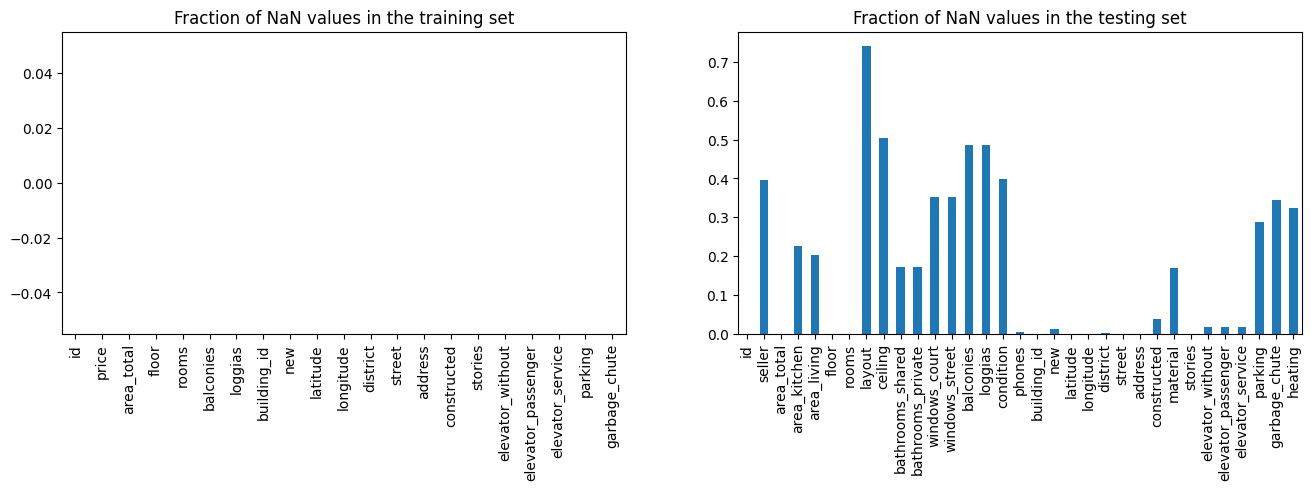

In [4]:
from sklearn.impute import SimpleImputer


# drop unecessary features
data_train.drop([
        'seller',
        'layout',
        'area_kitchen',
        'area_living',
        'bathrooms_shared',
        'bathrooms_private',
        'phones',
        'condition',
        'heating',
        'material', # experimental
        'ceiling',  # experimental
        'windows_court', # experimental
        'windows_street', # experimental
    ], 
    axis=1, 
    inplace=True
)

# drop rows
data_train.drop(data_train[data_train['district'].isna()].index, inplace=True)
data_train.drop(data_train[data_train['constructed'].isna()].index, inplace=True)

# fill data gaps
data_train['loggias'] = data_train['loggias'].fillna(0)
data_train['balconies'] = data_train['balconies'].fillna(0)

# the following two are experimental and may have to be replaced
data_train['parking'] = data_train['parking'].fillna(0)
data_train['garbage_chute'] = data_train['garbage_chute'].fillna(False)
data_train['elevator_without'] = data_train['elevator_without'].fillna(False)
data_train['elevator_passenger'] = data_train['elevator_passenger'].fillna(False)
data_train['elevator_service'] = data_train['elevator_service'].fillna(False)
data_train['new'] = data_train['new'].fillna(False)


fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
data_train.isna().mean().plot.bar(ax=ax1, title='Fraction of NaN values in the training set')
data_test.isna().mean().plot.bar(ax=ax2, title='Fraction of NaN values in the testing set')

# Feature Construction

In [5]:
# replacing longitude and latitude with distance in km
import math

moscow_center = [55.751244, 37.618423]
r = data_train[['latitude', 'longitude']].to_numpy()
d = [geopy.distance.distance(moscow_center, data).km for data in r]
data_train.drop(['latitude', 'longitude'], axis=1, inplace=True)
data_train['distance'] = d
data_train.head()

,id,price,area_total,floor,rooms,balconies,loggias,building_id,new,district,street,address,constructed,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,distance
0,0,7139520.0,59.2,2.0,2.0,0.0,0.0,4076,1.0,11.0,Бунинские Луга ЖК,к2.5/2,2021.0,9.0,0.0,1.0,1.0,1.0,False,24.703331
1,1,10500000.0,88.0,18.0,3.0,1.0,0.0,1893,0.0,2.0,улица Радужная,14к3,2010.0,25.0,0.0,1.0,1.0,1.0,False,12.619097
2,2,9019650.0,78.5,12.0,3.0,0.0,0.0,5176,1.0,6.0,Саларьево Парк ЖК,38,2021.0,15.0,0.0,1.0,1.0,1.0,False,11.741795
3,3,10500000.0,88.0,18.0,3.0,0.0,1.0,1893,0.0,2.0,улица Радужная,14к3,2010.0,25.0,0.0,1.0,1.0,1.0,False,12.619097
4,4,13900000.0,78.0,7.0,2.0,0.0,1.0,6604,0.0,11.0,улица Сервантеса,1к3,2017.0,15.0,0.0,1.0,1.0,1.0,0.0,20.725554


# Data Exploration

<AxesSubplot:>

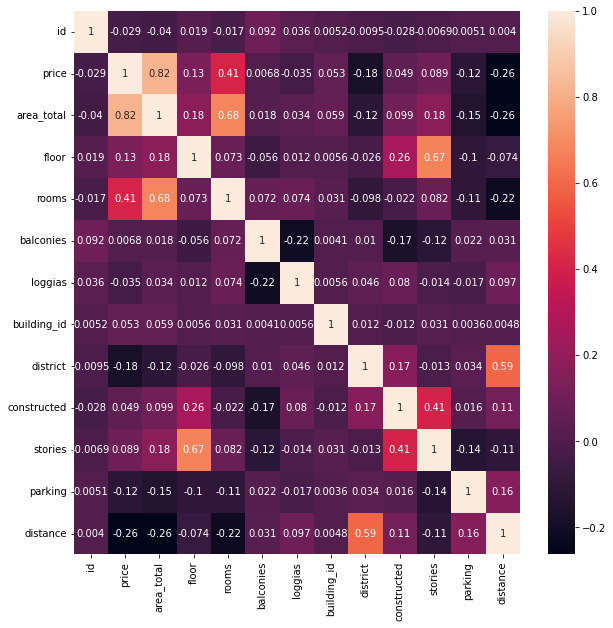

In [6]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(data_train.corr(), ax=ax, annot=True)

## Relevant features:
- distance
- area_total
- floor
- rooms

# Data Preparation

Text(0.5, 1.0, 'Validation set log prices')

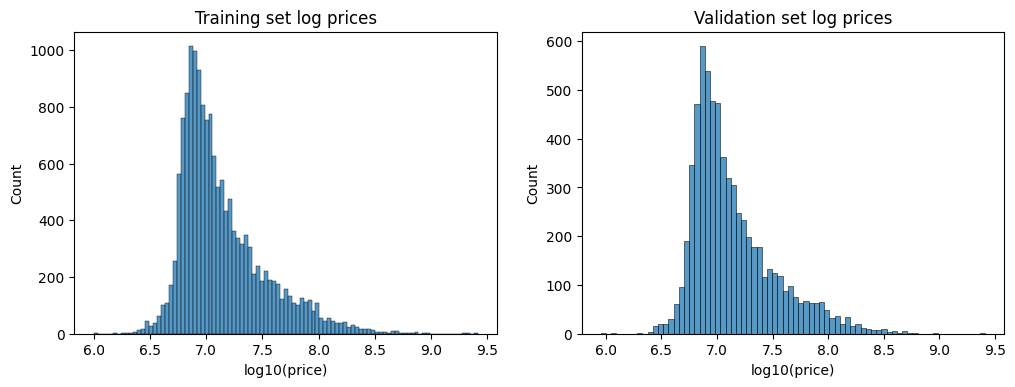

In [16]:
from sklearn.model_selection import train_test_split

X = data_train[['distance', 'area_total', 'floor', 'rooms']]
y = data_train['price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=np.log(data_train.price).round())

fig, (ax1, ax2) = plt.subplots(figsize=(12, 4), ncols=2, dpi=100)
sns.histplot(np.log10(y_train).rename('log10(price)'), ax=ax1)
sns.histplot(np.log10(y_val).rename('log10(price)'), ax=ax2)
ax1.set_title('Training set log prices'); ax2.set_title('Validation set log prices')

# Define Loss Function and Baseline

In [17]:
from sklearn.metrics import mean_squared_log_error

def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

mean = y_train.mean()
y_train_hat = np.full(len(y_train), mean)
y_val_hat = np.full(len(y_val), mean)
print(f'Train rmsle: {root_mean_squared_log_error(y_true=y_train, y_pred=y_train_hat) :.4f}')
print(f'Valid rmsle: {root_mean_squared_log_error(y_true=y_val, y_pred=y_val_hat) :.4f}')

Train rmsle: 1.0196
Valid rmsle: 1.0172


# Random Forest Regressor

In [56]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=100, criterion='mse')
rf_reg.fit(X_train, y_train)

y_pred = rf_reg.predict(X_val)
print(f'Valid rmsle: {root_mean_squared_log_error(y_true=y_val, y_pred=y_pred) :.4f}')

Valid rmsle: 0.2128
Valid rmsle: 0.8978


# Artificial Neural Network

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam

X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

model = Sequential()

model.add(Dense(X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))

model.compile(optimizer=Adam(0.0001), loss='mse')

r = model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              batch_size=1,
              epochs=100)

y_pred = model.predict(X_val)
print(f'Valid rmsle: {root_mean_squared_log_error(y_true=y_val, y_pred=y_pred) :.4f}')

Epoch 1/100
15652/15652 [==============================] - 32s 2ms/step - loss: 2473961828909056.0000 - val_loss: 1633088568295424.0000
Epoch 2/100
15652/15652 [==============================] - 29s 2ms/step - loss: 1535951574663168.0000 - val_loss: 1253154016460800.0000
Epoch 3/100
15652/15652 [==============================] - 29s 2ms/step - loss: 1320742843056128.0000 - val_loss: 1056444916957184.0000
Epoch 4/100
15652/15652 [==============================] - 29s 2ms/step - loss: 1177771837489152.0000 - val_loss: 955335883882496.0000
Epoch 5/100
15652/15652 [==============================] - 31s 2ms/step - loss: 1095042982739968.0000 - val_loss: 923233620590592.0000
Epoch 6/100
 7354/15652 [=============>................] - ETA: 14s - loss: 1049498679771136.0000

KeyboardInterrupt: 